## Практическое задание №3 Выбор параметров квантования сигнала

**Цель**

Ознакомиться с понятием квантование и научиться квантовать непрерывную функцию изображения


In [4]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from PIL import Image
from math import pi
import cv2
import math 
import pandas as pd
from skimage.metrics import structural_similarity as ssim

In [29]:
width = 22.5 # mm
resolution = 6000 #px
fs = round((width/ resolution), 4)
period = round(1 / fs, 3)

print(fs)
print(period)

0.0037
270.27


In [28]:
def sin(x, frequency, phase):
    return 0.5 + 0.5*np.sin(frequency * x*np.pi + phase)

In [30]:
def get_image(y):
    print(min(y),max(y))
    y = np.array(y)*255
    x = np.array([y for _ in range(301)])
    data = Image.fromarray(x)
    plt.imshow(data)
    #plt.axis("off")
    plt.show()

In [31]:
def get_mat(y):
    y = np.array(y)*255
    x = np.array([y for _ in range(301)])
    return x 

In [32]:
def discretization(freq, phase):
    height = 300
    y = []
    x = 0.0
    print(freq)
    while x < 1/fs * height:
        y0 = integrate.quad(lambda x: sin(x, freq, phase), x, x+1/fs)[0]/period
        y.append(round(y0,2))
        x += 1/fs

    get_image(y)
    return y 

In [ ]:
pars = [1/5, 1/3, 1/2, 1, 1.41, 2, 3, 4, 5, 6,7,10]
list_sample = []
for i, par  in enumerate(pars):
    list_sample.append(discretization(par*fs, 0))

In [ ]:
for i, par  in enumerate(pars):
    discretization(par*fs, 1)

In [36]:
# метрика MSE
def MSE(img1, img2):
    return np.mean((img1 - img2)**2)


In [37]:
# метрика PSNR
def PSNR(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = MSE(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [39]:
# метрика SSIM
def SSIM(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

In [40]:
# Равноменое квантование 
def quantize_uniform(x, quant_min=0.0, quant_max=1.0, quant_level=2):
    
    x_normalize = (x-quant_min) * (quant_level-1) / (quant_max-quant_min)
    x_normalize[x_normalize > quant_level - 1] = quant_level - 1
    x_normalize[x_normalize < 0] = 0
    x_normalize_quant = np.around(x_normalize)
    x_quant = (x_normalize_quant) * (quant_max-quant_min) / (quant_level-1) + quant_min
    return x_quant


Число уровней квантования задается следующее 2, 8, 32, 64, 128 и 256.

In [41]:
lvl_quant = [2, 8, 32, 64, 128, 256]

In [42]:
# 1 изображение 
def get_statistics(im, check = True, quant_min=0.1, quant_max=.9):
    MSE_ = ['MSE']
    PSNR_ = ['PSNR']
    SSIM_ = ['SSIM']
    f  = plt.figure(figsize=(60,60))
    # отображение изображений
    for i, lvl in enumerate(lvl_quant):
        img = quantize_uniform(np.array(im),quant_min=quant_min, quant_max=quant_max, quant_level=lvl)
        MSE_.append(MSE(np.array(im), np.array(img)))
        PSNR_.append(PSNR(np.array(im), np.array(img)))
        SSIM_.append(ssim(np.array(im), np.array(img)))

        f.add_subplot(1,13, i+1)
        plt.grid(False)
        if check:
            plt.imshow(get_mat(img), cmap='gray')
        else:
            plt.imshow(img, cmap='gray')
    # отображение метрик
    df = pd.DataFrame(({'func':[], 'LV_2': [], 'LV_8': [], 'LV_32': [],'LV_64': [], 'LV_128': [], 'LV_256': []}))
    df.loc[ len(df.index )] = MSE_
    df.loc[ len(df.index )] = PSNR_
    df.loc[ len(df.index )] = SSIM_
    plt.show()
    print(df)
    
    return df

In [45]:
pd.options.display.expand_frame_repr = False

Cгенерировать синусоидальный сигнал и провести его
дискретизацию и квантование.

 Границы интервала квантования [0; 1]

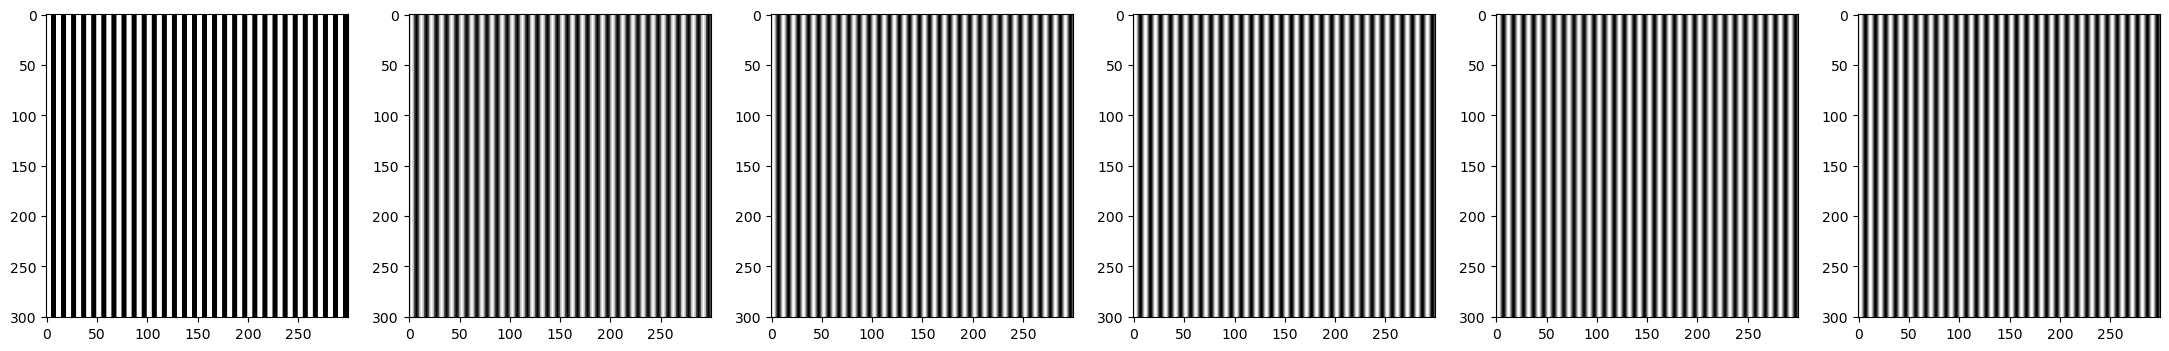

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.053020   0.002408   0.000034   0.000016   0.000008    0.000003
1  PSNR  60.886406  74.314680  92.876782  96.030105  99.014979  104.073627
2  SSIM   0.830620   0.987173   0.999840   0.999921   0.999957    0.999989


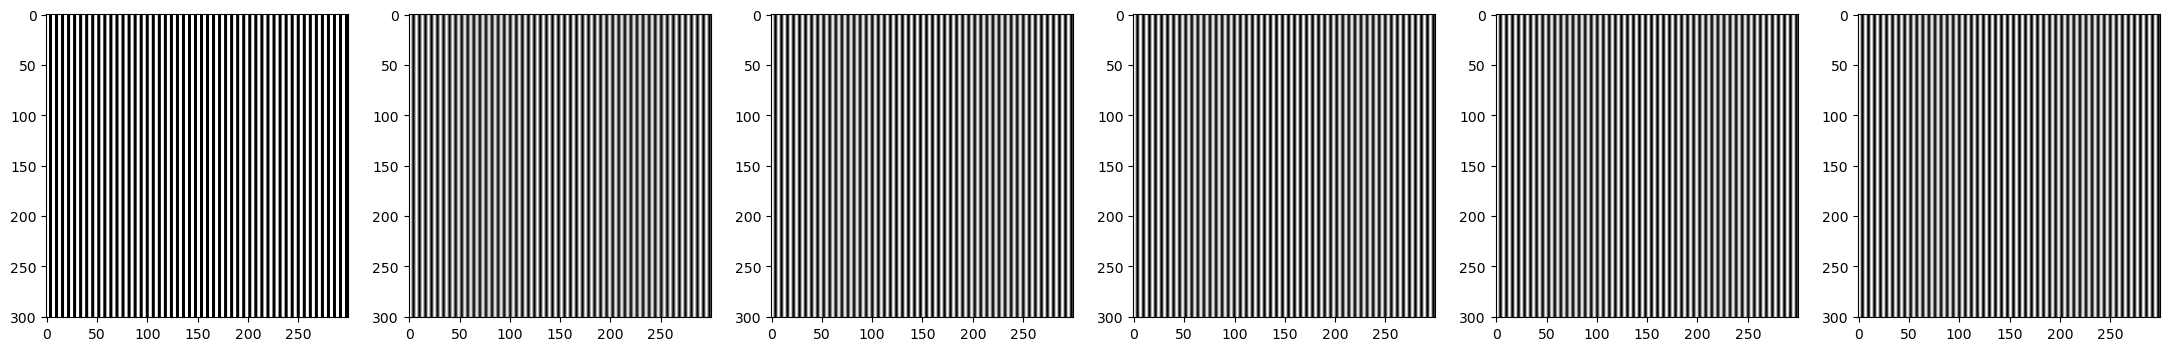

   func       LV_2       LV_8      LV_32      LV_64      LV_128        LV_256
0   MSE   0.045200   0.000574   0.000053   0.000030    0.000004  9.739844e-07
1  PSNR  61.579419  80.540552  90.922258  93.369450  101.706545  1.082453e+02
2  SSIM   0.875256   0.997477   0.999771   0.999871    0.999981  9.999957e-01


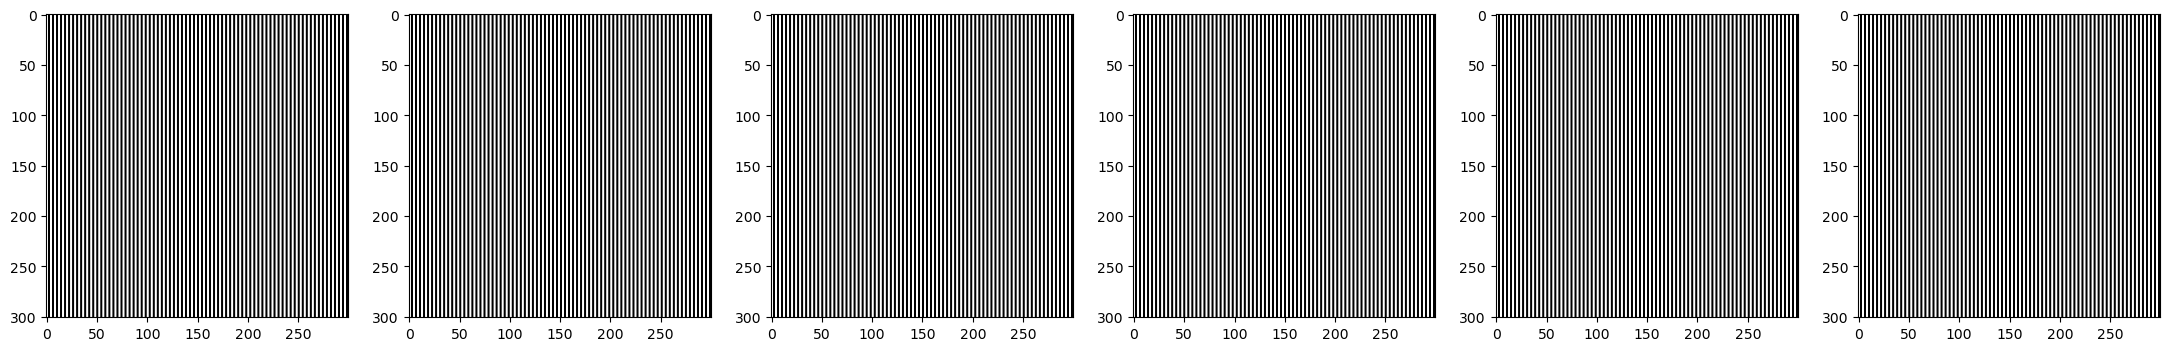

   func       LV_2       LV_8      LV_32      LV_64      LV_128        LV_256
0   MSE   0.032400   0.001380   0.000184   0.000029    0.000001  1.537870e-07
1  PSNR  63.025354  76.733297  85.493052  93.488036  107.284317  1.162616e+02
2  SSIM   0.907623   0.994024   0.999072   0.999861    0.999994  9.999993e-01


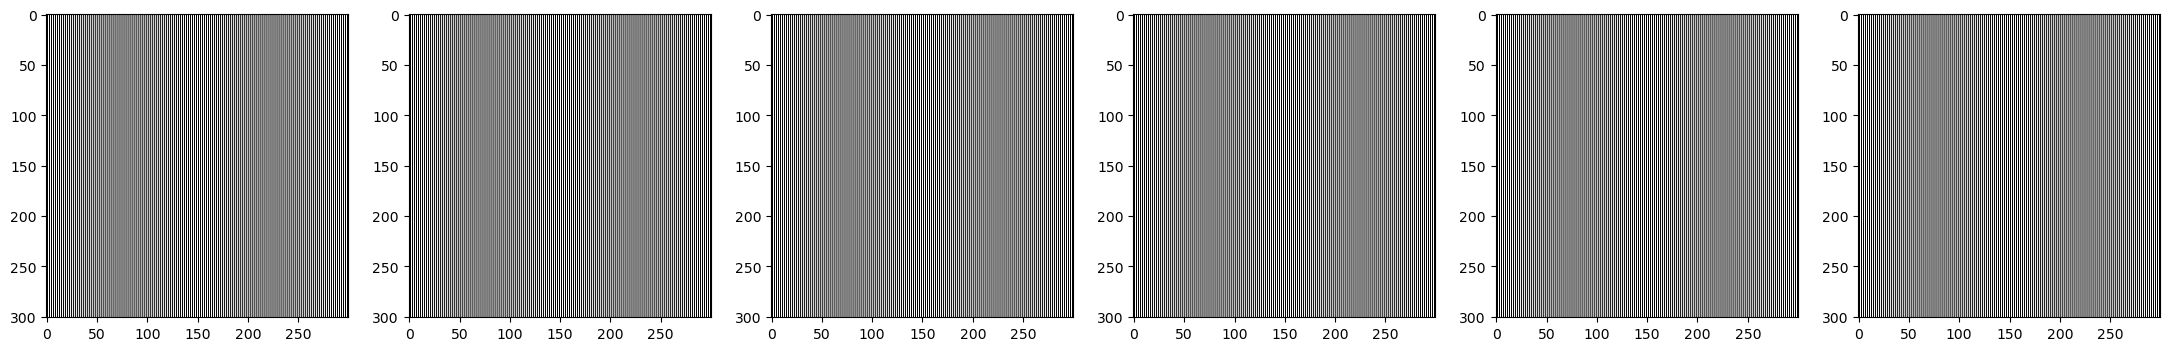

   func       LV_2       LV_8      LV_32      LV_64      LV_128        LV_256
0   MSE   0.032400   0.001380   0.000184   0.000029    0.000001  1.537870e-07
1  PSNR  63.025354  76.733297  85.493052  93.488036  107.284317  1.162616e+02
2  SSIM   0.907623   0.994024   0.999072   0.999861    0.999994  9.999993e-01


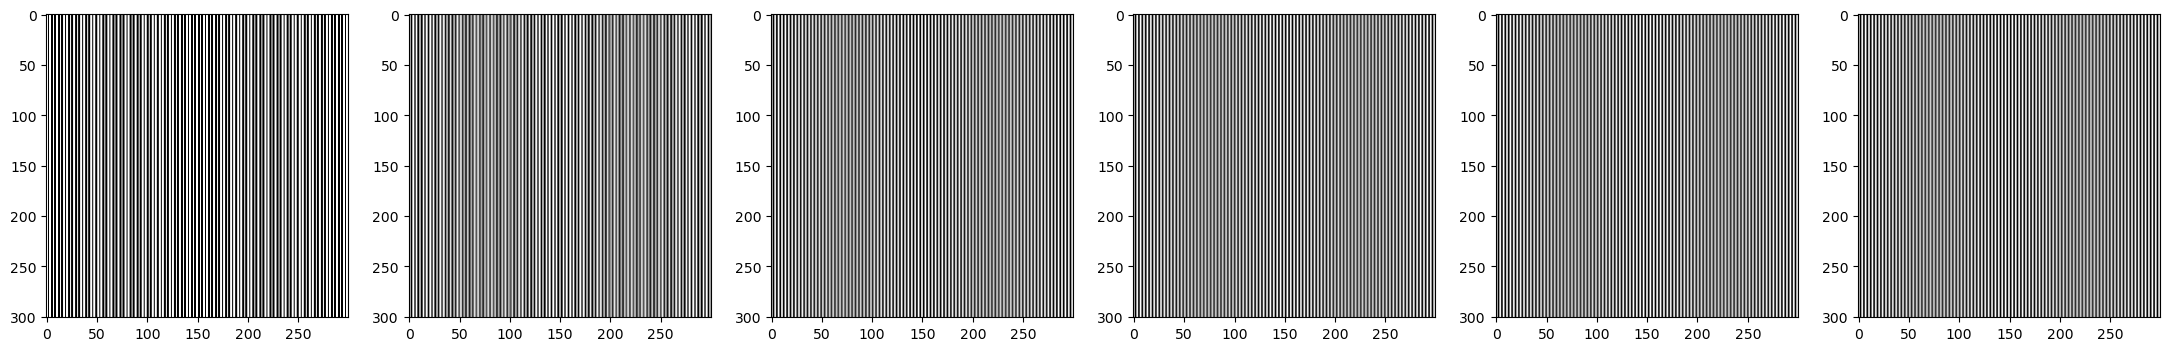

   func       LV_2       LV_8      LV_32      LV_64      LV_128      LV_256
0   MSE   0.151654   0.001997   0.000081   0.000019    0.000005    0.000001
1  PSNR  56.322265  75.127334  89.042997  95.382897  100.934920  106.848978
2  SSIM   0.440219   0.960544   0.998008   0.999516    0.999888    0.999966


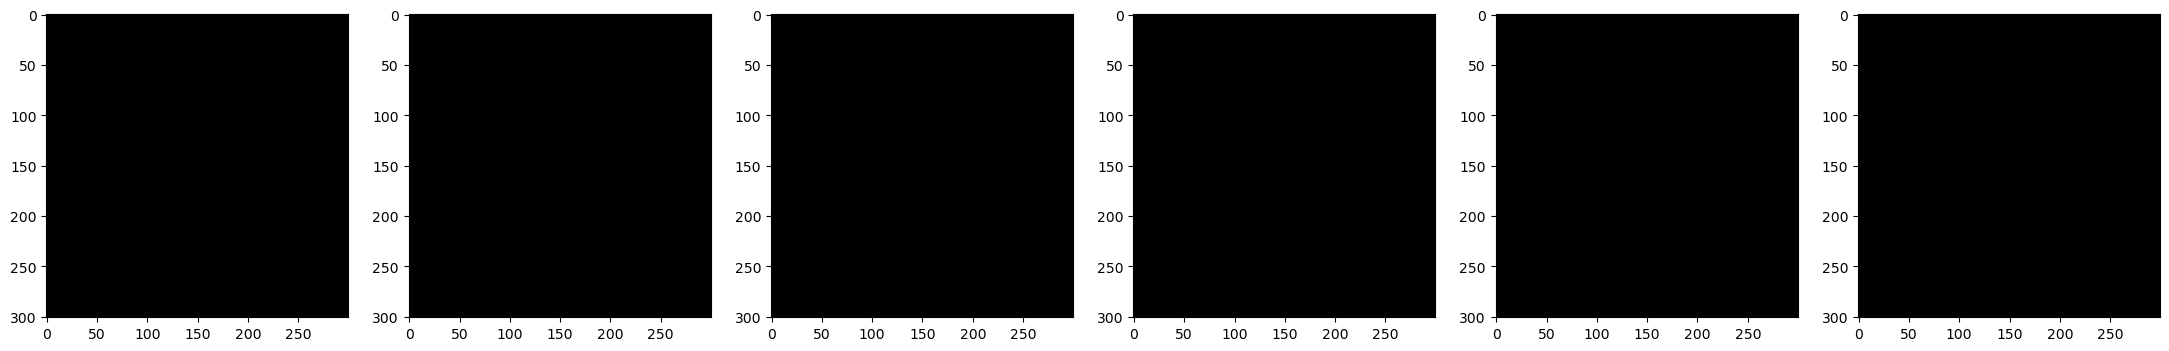

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.250000   0.005102   0.000260   0.000063   0.000016    0.000004
1  PSNR  54.151404  71.053364  83.978637  90.138215  96.227478  102.282207
2  SSIM   0.001597   0.991157   0.999497   0.999876   0.999969    0.999992


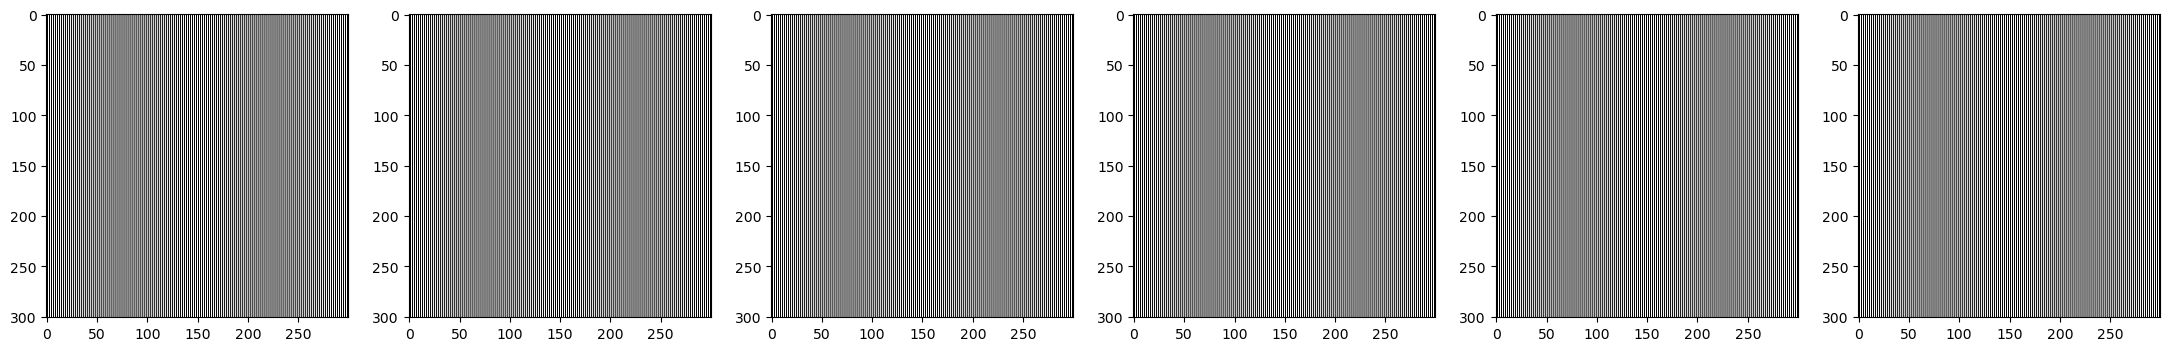

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.152100   0.001488   0.000008   0.000047   0.000014    0.000003
1  PSNR  56.309511  76.405489  98.873187  91.448245  96.764921  103.197357
2  SSIM   0.423880   0.926843   0.999699   0.998199   0.999484    0.999888


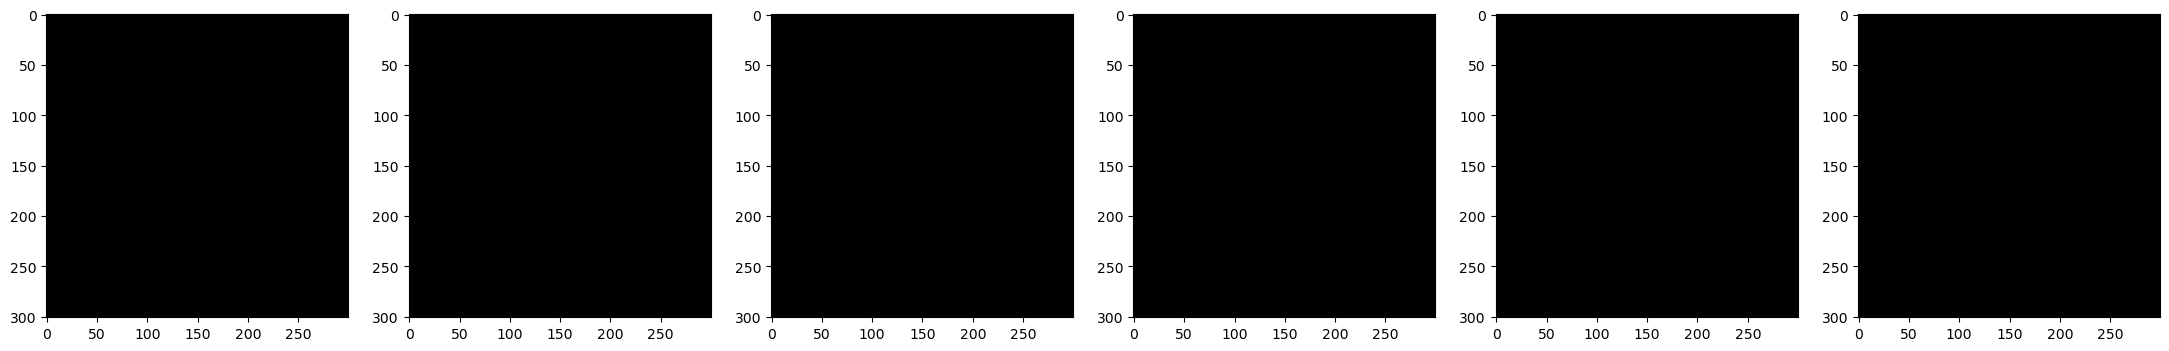

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.250000   0.005102   0.000260   0.000063   0.000016    0.000004
1  PSNR  54.151404  71.053364  83.978637  90.138215  96.227478  102.282207
2  SSIM   0.001597   0.991157   0.999497   0.999876   0.999969    0.999992


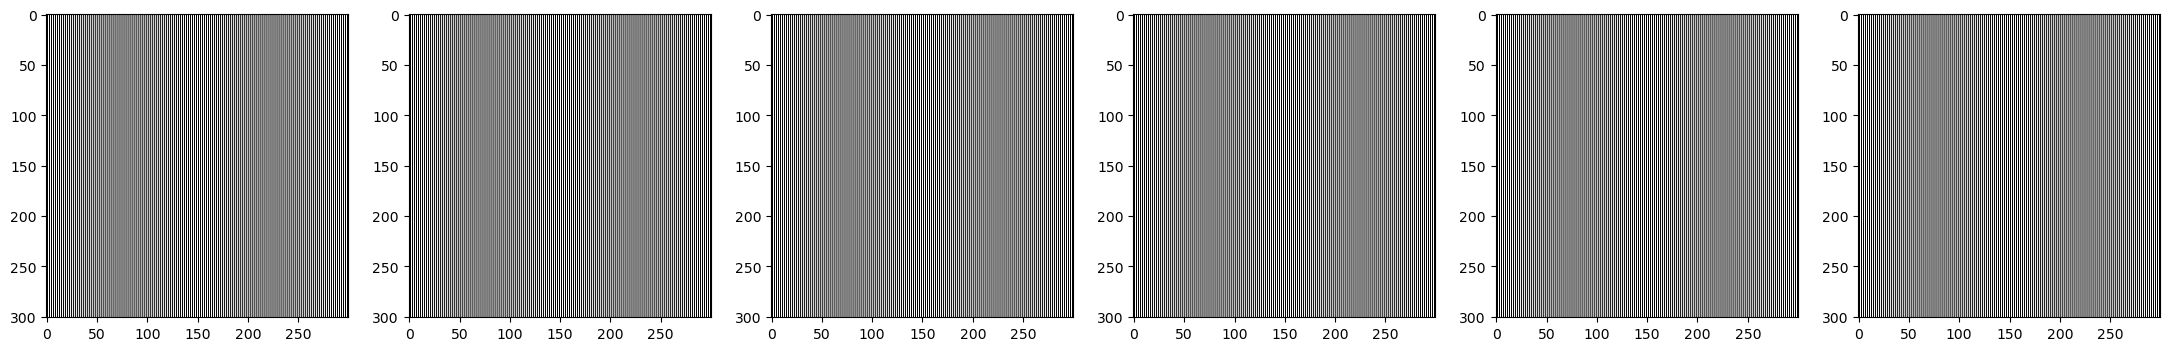

   func       LV_2       LV_8      LV_32      LV_64        LV_128        LV_256
0   MSE   0.193600   0.000131   0.000135   0.000020  8.928018e-07  6.151480e-07
1  PSNR  55.261750  86.970965  86.831987  95.174454  1.086233e+02  1.102410e+02
2  SSIM   0.243988   0.988974   0.985161   0.997991  9.999128e-01  9.999411e-01


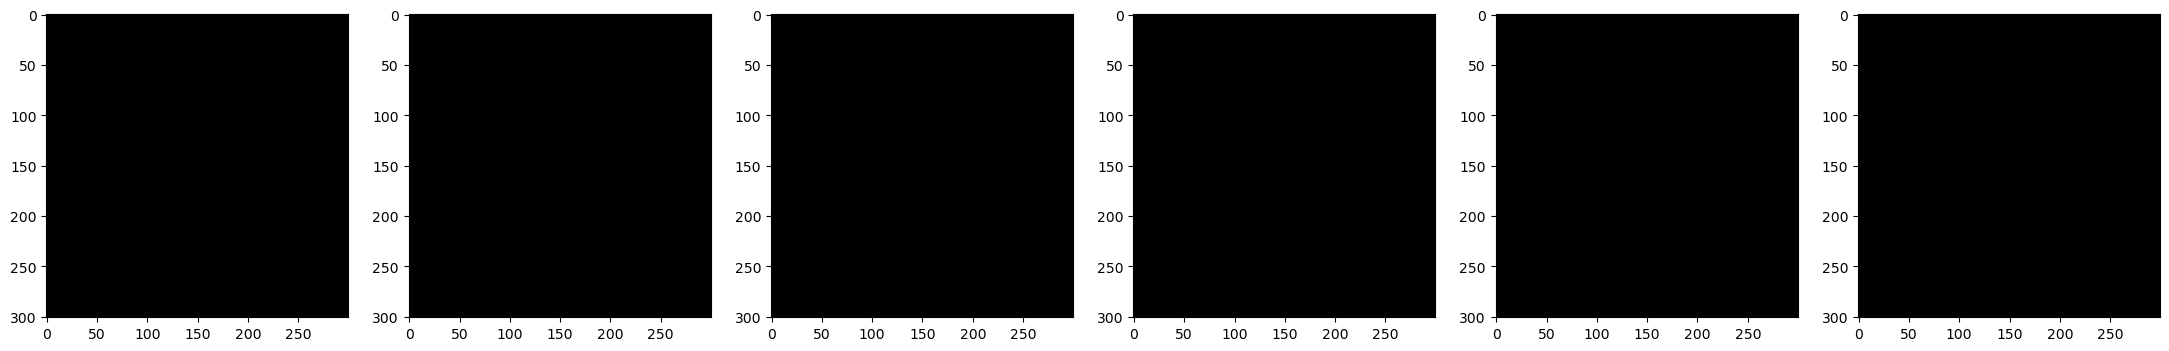

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.250000   0.005102   0.000260   0.000063   0.000016    0.000004
1  PSNR  54.151404  71.053364  83.978637  90.138215  96.227478  102.282207
2  SSIM   0.001597   0.991157   0.999497   0.999876   0.999969    0.999992


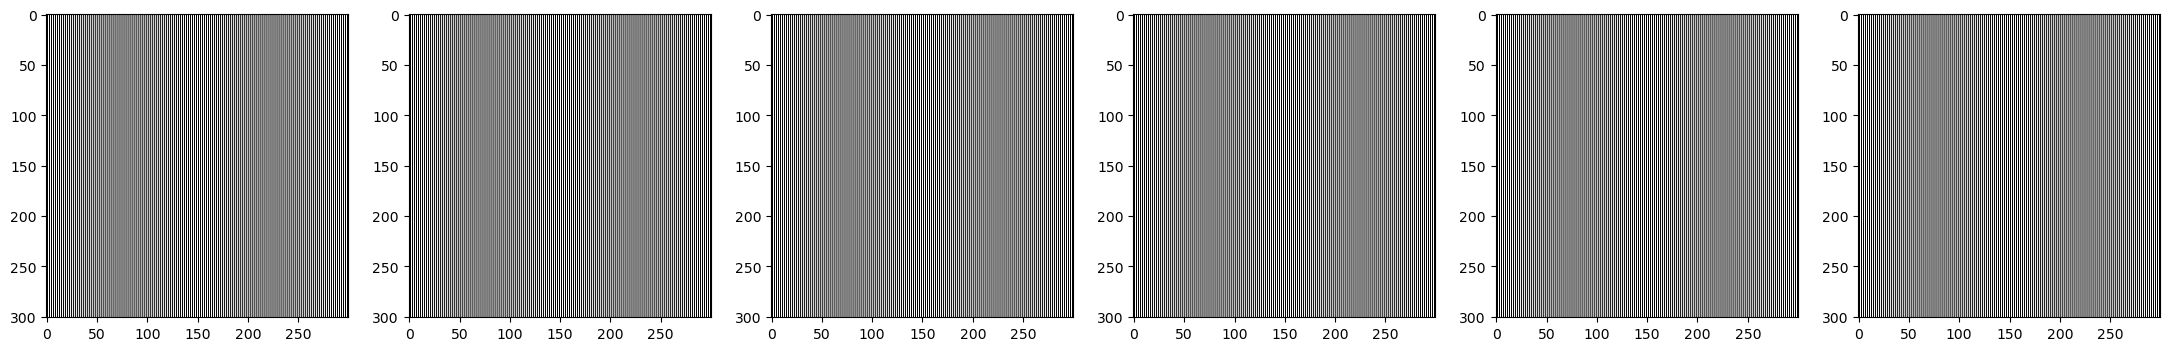

   func       LV_2       LV_8       LV_32      LV_64      LV_128        LV_256
0   MSE   0.202500   0.000459    0.000003   0.000031    0.000001  9.611688e-07
1  PSNR  55.066553  81.510939  103.978637  93.236254  106.685053  1.083028e+02
2  SSIM   0.206160   0.957275    0.999674   0.996466    0.999831  9.998806e-01


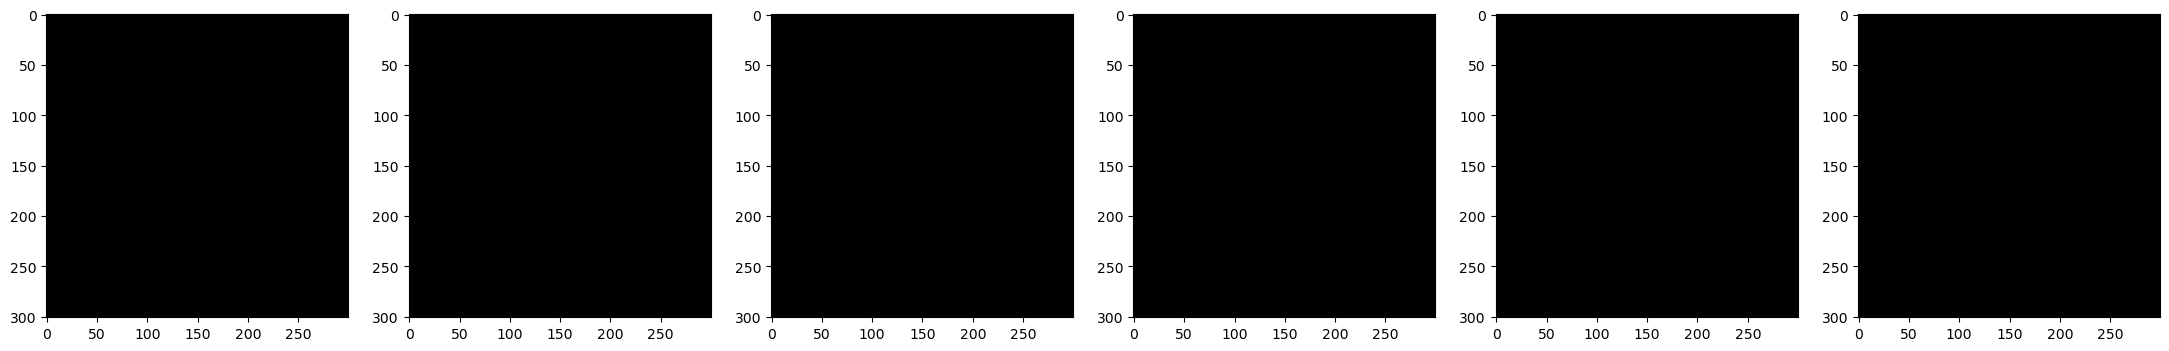

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.250000   0.005102   0.000260   0.000063   0.000016    0.000004
1  PSNR  54.151404  71.053364  83.978637  90.138215  96.227478  102.282207
2  SSIM   0.001597   0.991157   0.999497   0.999876   0.999969    0.999992


In [46]:
list_df = []
for im in list_sample:
    list_df.append(get_statistics(im, quant_min=0., quant_max=1.))

 Границы интервала квантования [0.1; 0.9]

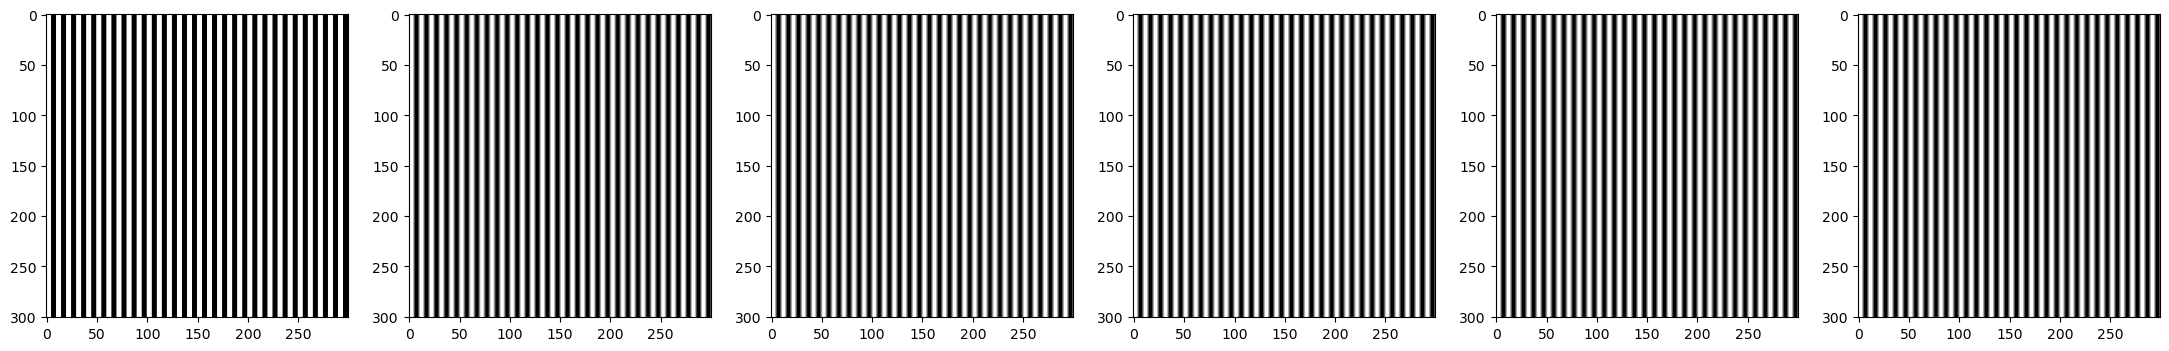

   func       LV_2       LV_8      LV_32      LV_64     LV_128     LV_256
0   MSE   0.026620   0.001804   0.001646   0.001626   0.001622   0.001620
1  PSNR  63.878723  75.569224  75.966467  76.018800  76.031500  76.034623
2  SSIM   0.885750   0.991143   0.992044   0.992162   0.992191   0.992198


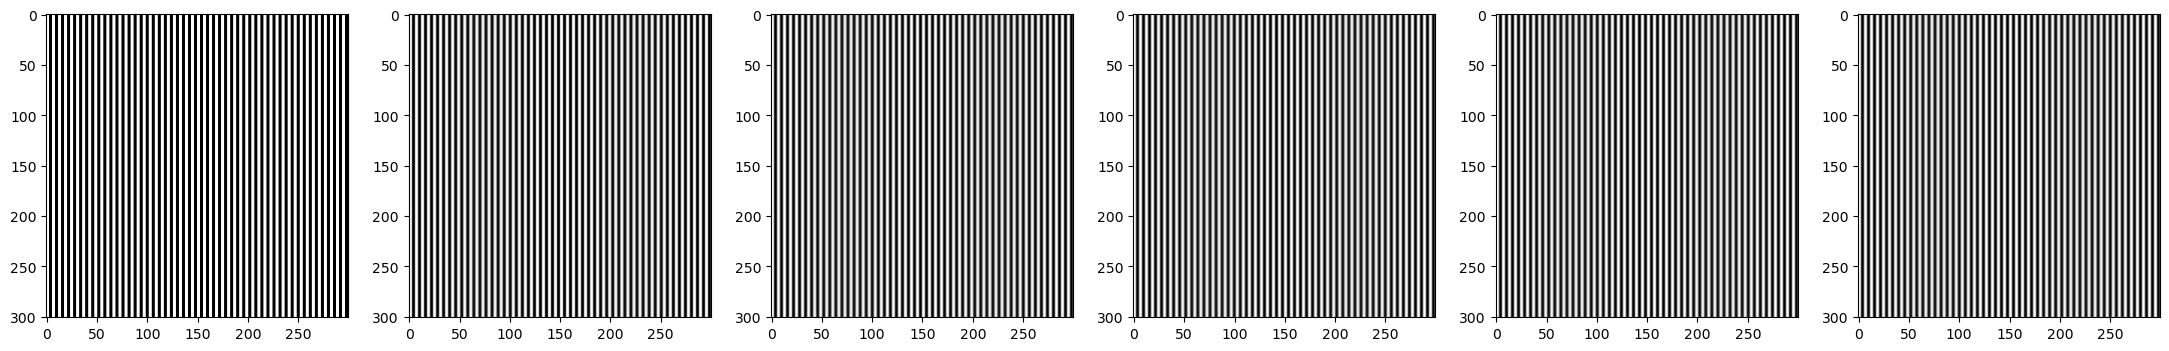

   func       LV_2       LV_8      LV_32      LV_64     LV_128     LV_256
0   MSE   0.019200   0.003527   0.002151   0.002151   0.002138   0.002133
1  PSNR  65.297791  72.657327  74.804213  74.805342  74.831609  74.840216
2  SSIM   0.930040   0.984263   0.989823   0.989668   0.989848   0.989830


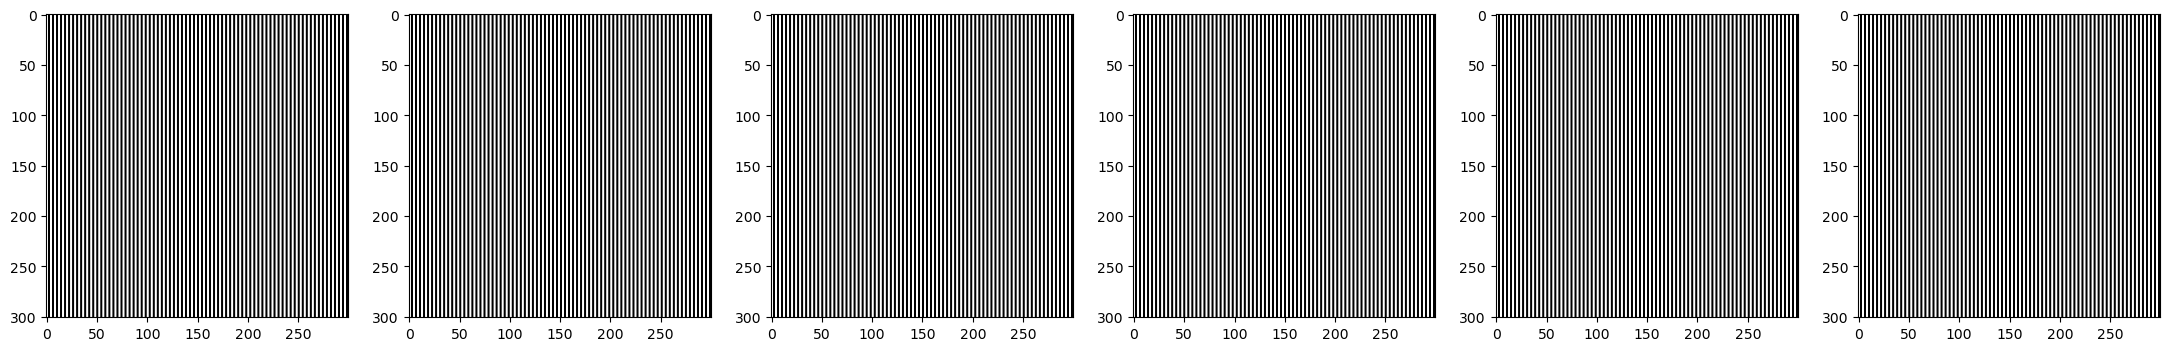

   func       LV_2       LV_8      LV_32      LV_64      LV_128      LV_256
0   MSE   0.006400   0.001176   0.000007   0.000015    0.000004    0.000002
1  PSNR  70.069004  77.428540  99.896238  96.513390  102.602653  104.220407
2  SSIM   0.975636   0.993671   0.999968   0.999930    0.999983    0.999995


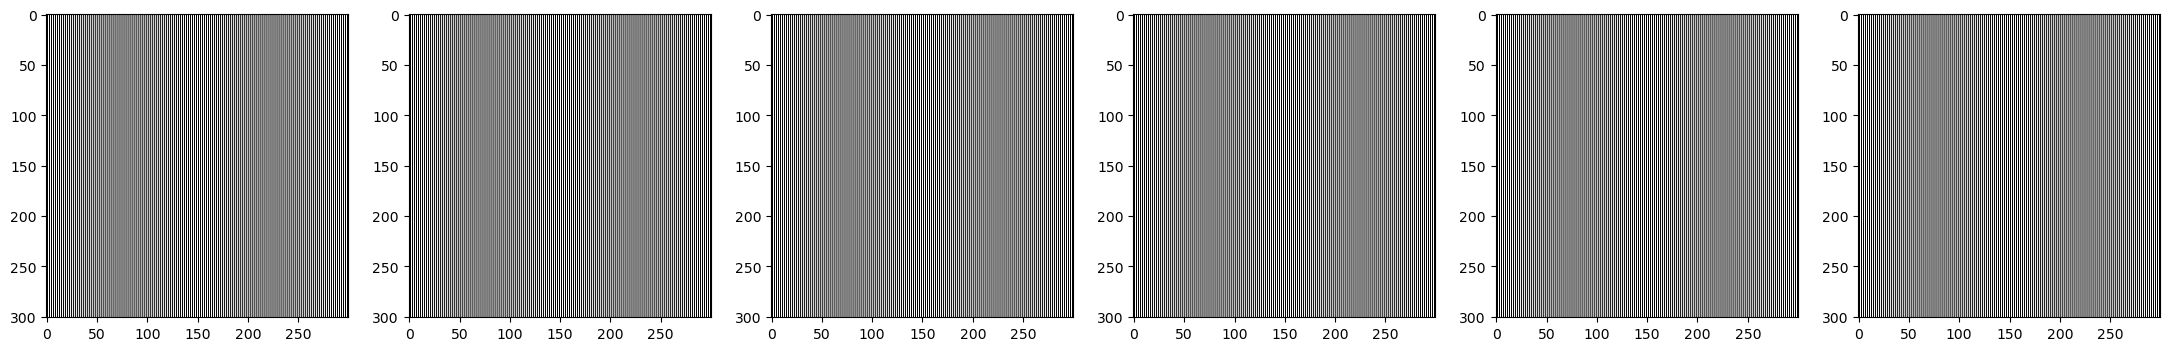

   func       LV_2       LV_8      LV_32      LV_64      LV_128      LV_256
0   MSE   0.006400   0.001176   0.000007   0.000015    0.000004    0.000002
1  PSNR  70.069004  77.428540  99.896238  96.513390  102.602653  104.220407
2  SSIM   0.975636   0.993671   0.999968   0.999930    0.999983    0.999995


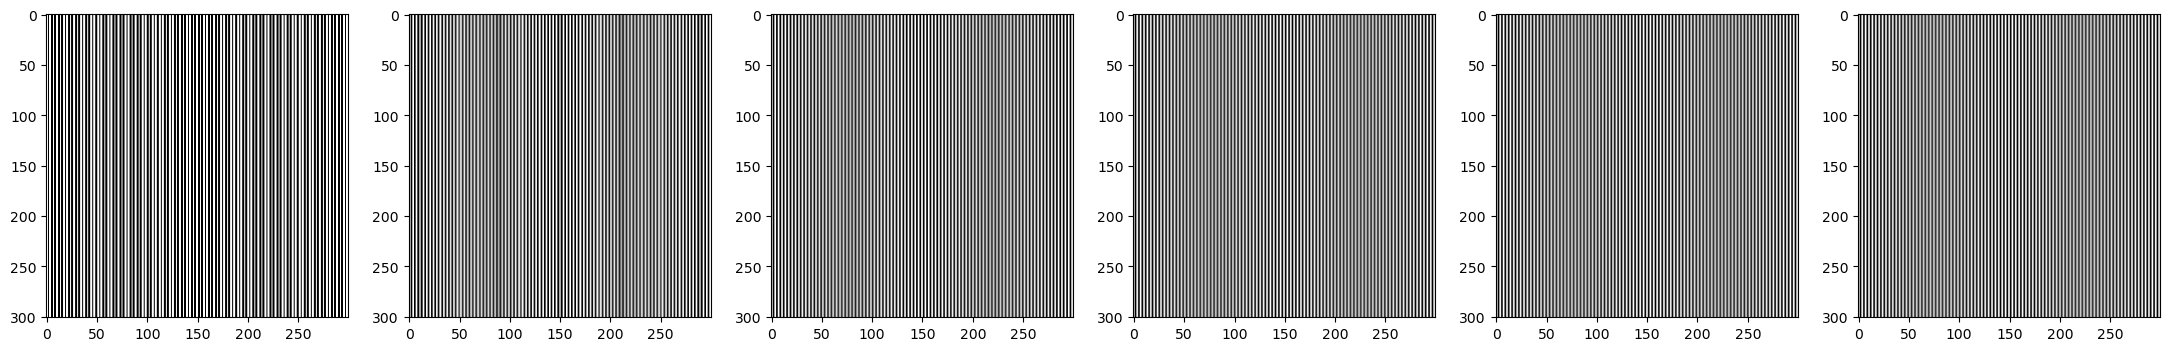

   func       LV_2       LV_8      LV_32      LV_64      LV_128        LV_256
0   MSE   0.084574   0.000799   0.000067   0.000013    0.000003  8.173779e-07
1  PSNR  58.858435  79.103672  89.868235  96.947071  103.171729  1.090066e+02
2  SSIM   0.534030   0.981719   0.998453   0.999710    0.999924  9.999797e-01


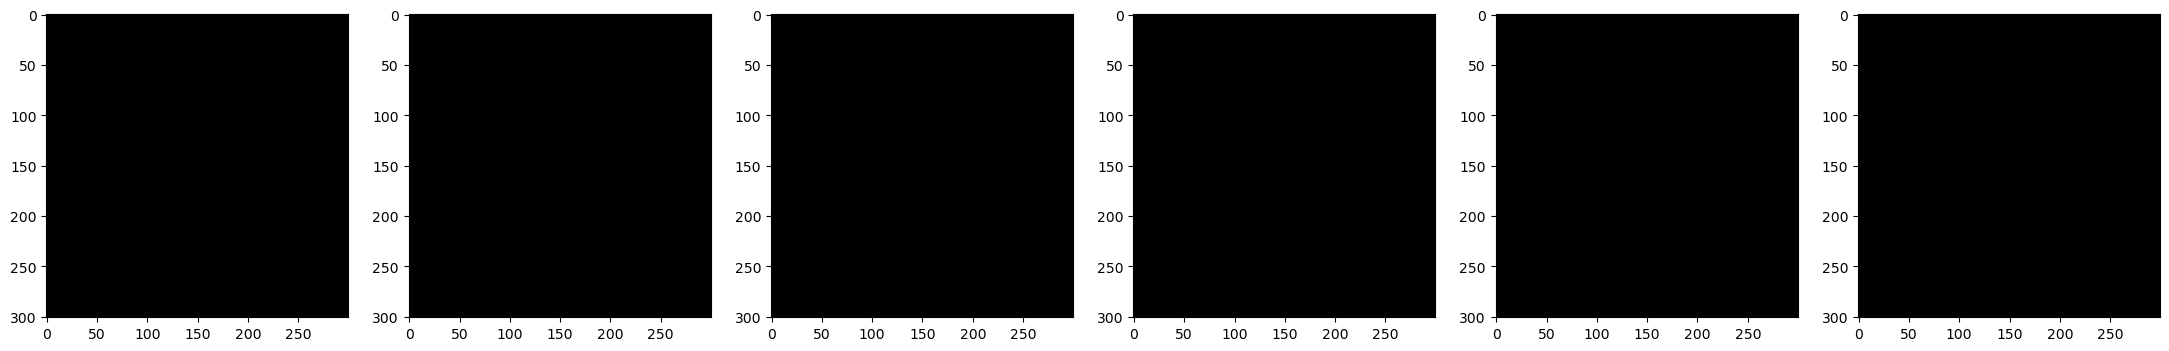

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.160000   0.003265   0.000166   0.000040   0.000010    0.000002
1  PSNR  56.089604  72.991565  85.916838  92.076415  98.165678  104.220407
2  SSIM   0.385561   0.994177   0.999676   0.999920   0.999980    0.999995


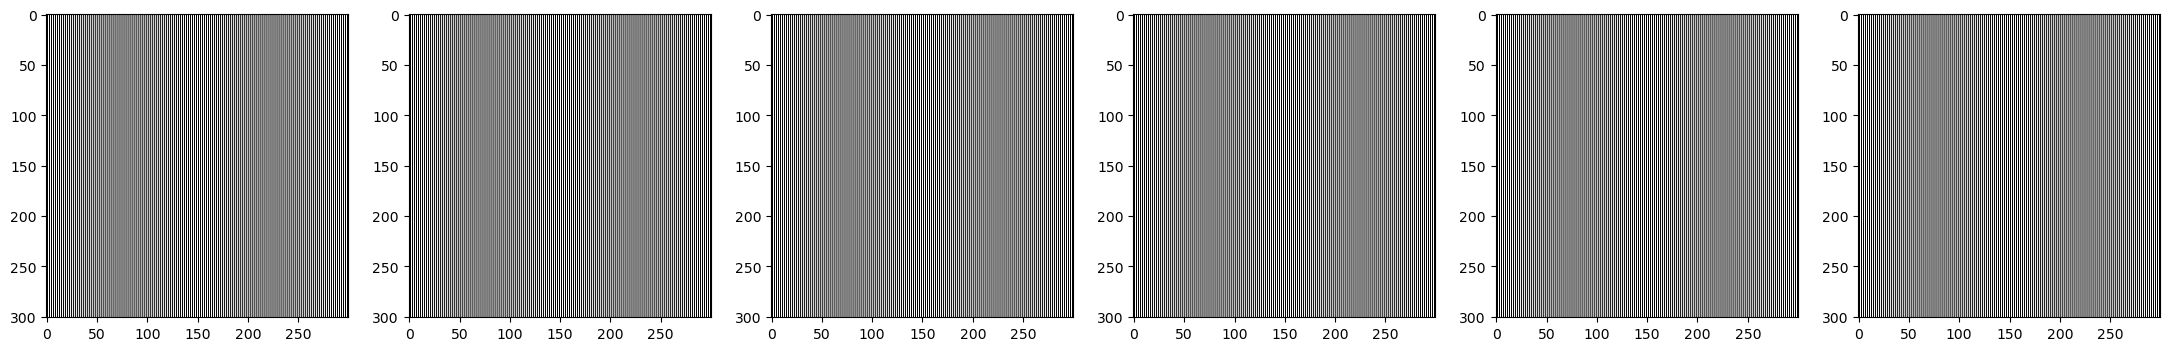

   func       LV_2       LV_8      LV_32       LV_64        LV_128      LV_256
0   MSE   0.084100   0.002794   0.000038    0.000004  5.580011e-08    0.000002
1  PSNR  58.882844  73.668730  92.382965  101.838748  1.206645e+02  105.380246
2  SSIM   0.518305   0.849008   0.998691    0.999842  9.999980e-01    0.999932


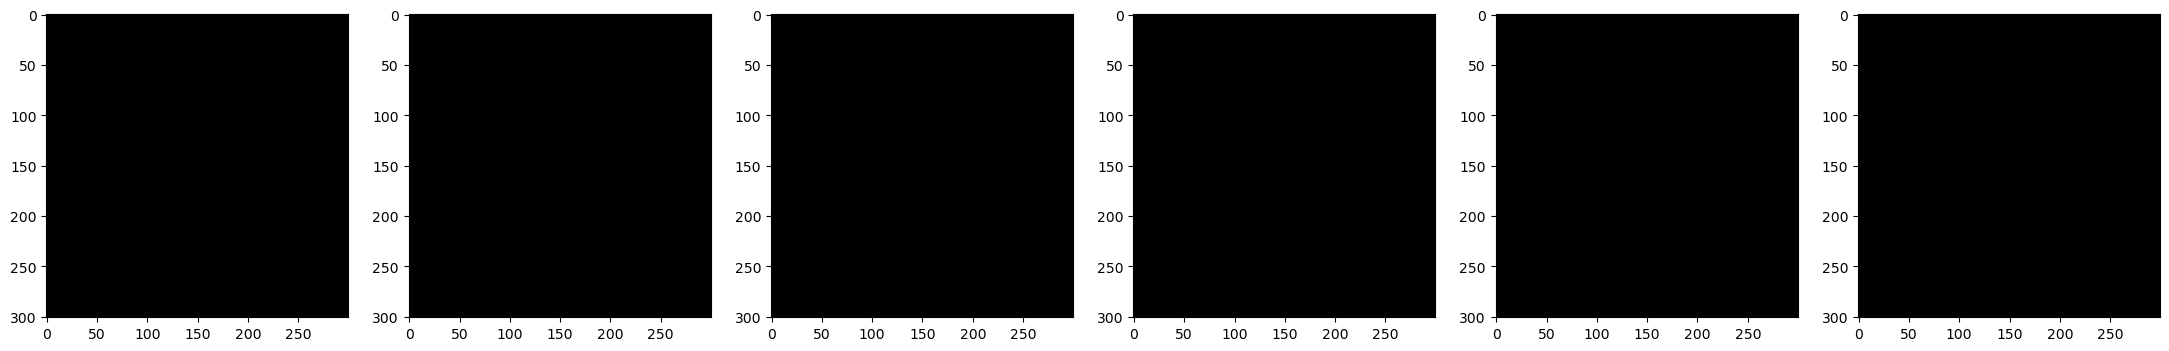

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.160000   0.003265   0.000166   0.000040   0.000010    0.000002
1  PSNR  56.089604  72.991565  85.916838  92.076415  98.165678  104.220407
2  SSIM   0.385561   0.994177   0.999676   0.999920   0.999980    0.999995


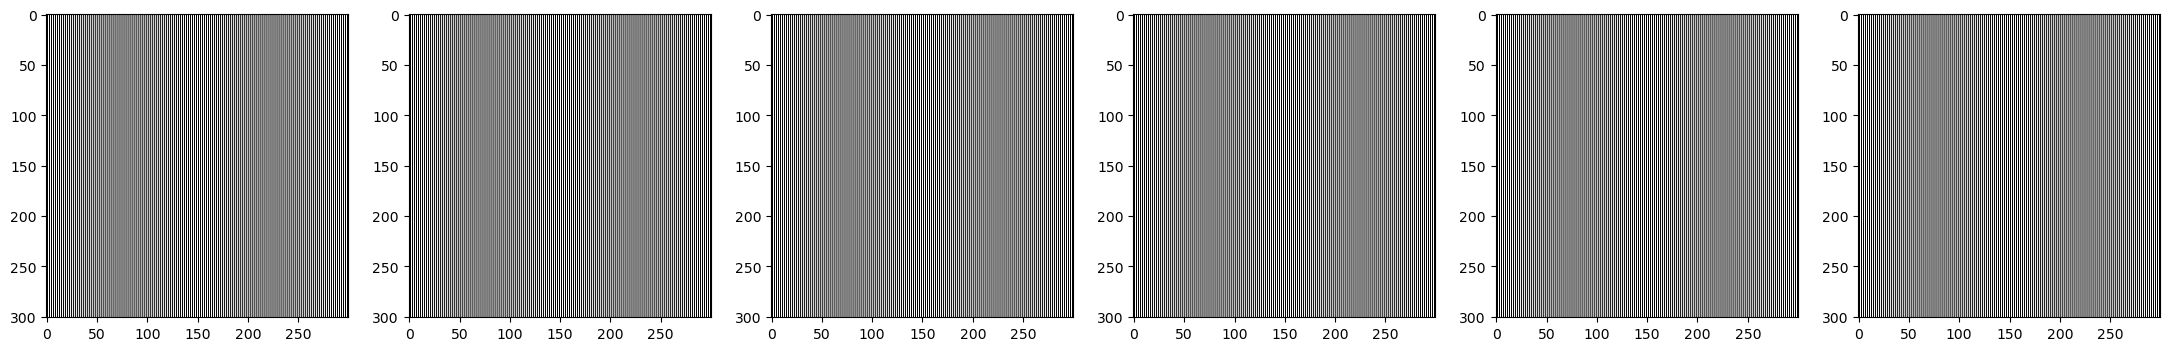

   func       LV_2       LV_8      LV_32      LV_64        LV_128      LV_256
0   MSE   0.115600   0.000008   0.000020   0.000008  2.480005e-08    0.000001
1  PSNR  57.501225  99.012164  95.035477  99.012164  1.241863e+02  106.719182
2  SSIM   0.305285   0.999185   0.998130   0.999185  9.999976e-01    0.999868


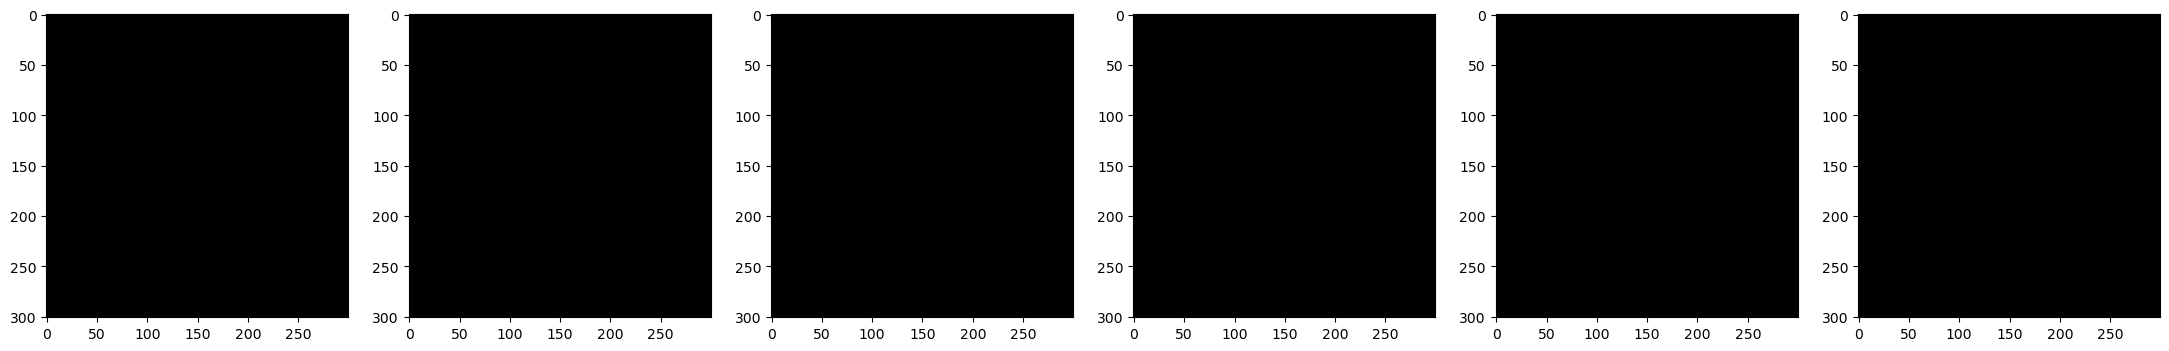

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.160000   0.003265   0.000166   0.000040   0.000010    0.000002
1  PSNR  56.089604  72.991565  85.916838  92.076415  98.165678  104.220407
2  SSIM   0.385561   0.994177   0.999676   0.999920   0.999980    0.999995


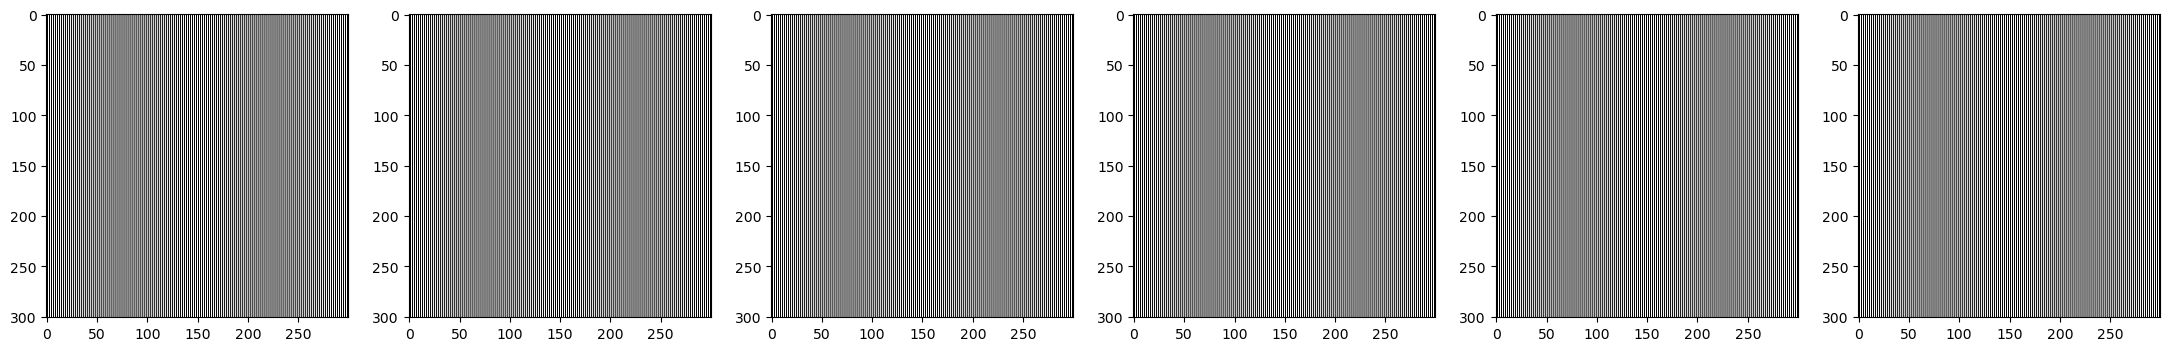

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.122500   0.000051   0.000127   0.000031   0.000008    0.000002
1  PSNR  57.249443  91.053364  87.076677  93.236254  99.325517  105.380246
2  SSIM   0.259175   0.994275   0.982163   0.995951   0.999036    0.999765


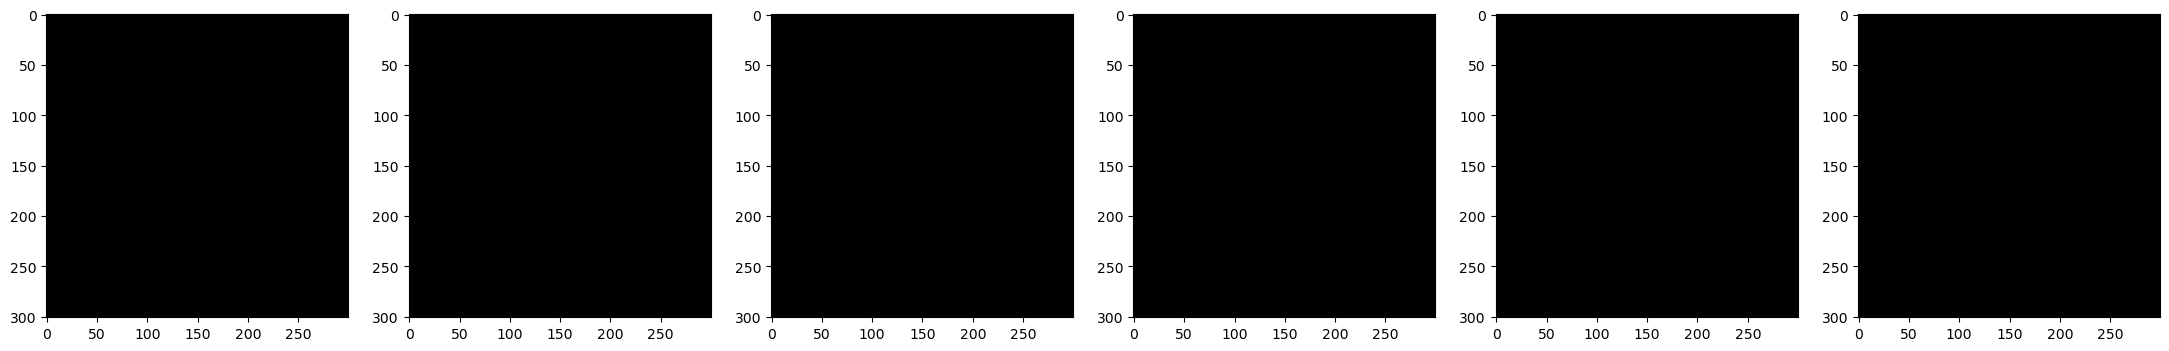

   func       LV_2       LV_8      LV_32      LV_64     LV_128      LV_256
0   MSE   0.160000   0.003265   0.000166   0.000040   0.000010    0.000002
1  PSNR  56.089604  72.991565  85.916838  92.076415  98.165678  104.220407
2  SSIM   0.385561   0.994177   0.999676   0.999920   0.999980    0.999995


In [47]:
list_df = []
for im in list_sample:
    list_df.append(get_statistics(im, quant_min=0.1, quant_max=0.9))

In [11]:
import random

In [21]:
# неравномерное квантование

def irregularly_quantization(y, low_thresh = 1, high_thresh =255, count = 2) : 
    mss = []
    levels = []
    i = 0
    levels.append(low_thresh)
    h,w = y.shape
    y = y.flatten()
    
    while low_thresh < high_thresh:
        check = count - i
        if (check > 1):
            offset = ((high_thresh - low_thresh) / (count - i)) / 2
            ran = random.uniform(-offset, offset)
            low_thresh += ran
        else:
            low_thresh = high_thresh
        levels.append(low_thresh)
        i+=1
        

    for i in y:
        for j in range(len(levels)):
            if i < levels[j]:
                if i < (levels[j-1] + levels[j]) / 2:
                    mss.append(levels[j-1])
                    break
                else:
                    mss.append(levels[j])
                    break

    return np.reshape(np.array(mss),(h,w))

In [16]:
# получение гистограммы 
def getHist(img):
    plt.hist(img.ravel(), 256, [0, 256])
    plt.show()

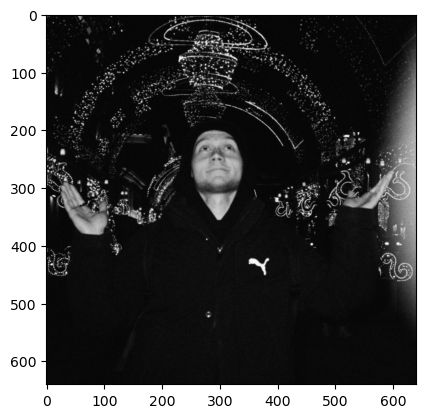

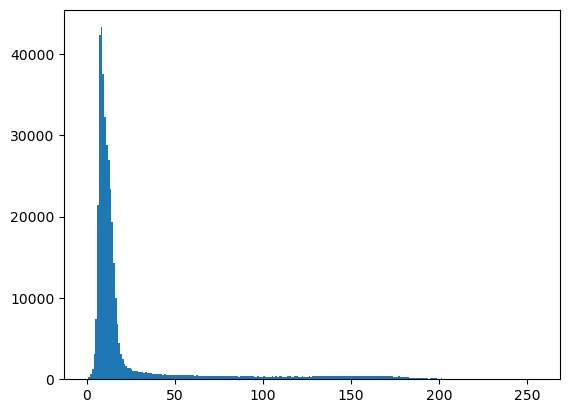

In [17]:
image_path = r'E:\GitHub\Mag_2_semester\ImageProcessing\PW_3\images\image_1.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap = 'gray')
plt.show()
getHist(image)

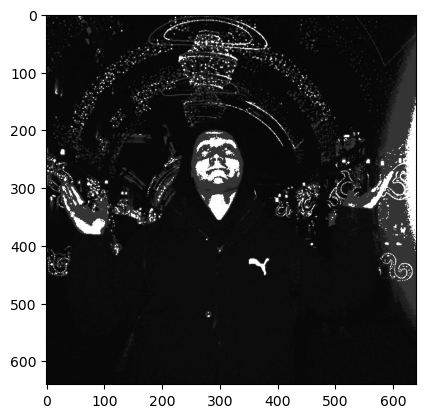

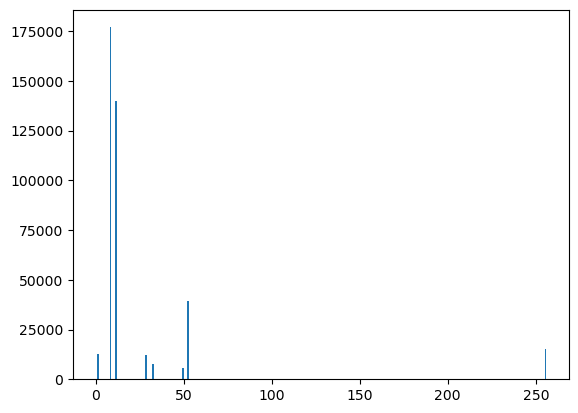

In [27]:
df_img=irregularly_quantization(image, low_thresh = 0, high_thresh =255, count = 8)
plt.imshow(df_img, cmap ='gray')
plt.show()
getHist(df_img)

## Вывод

Увеличение кол-во уровней квантования и границ интервала улучшает качество изображения
